In [1]:
# Import all necessary modules

import os
import math
import pandas as pd
import numpy as np
from umap import UMAP
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
from scipy.spatial.distance import cdist
import scipy.stats as ss
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors as CD
from IPython.display import SVG
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Read in the data from a .csv file and generate a list with inchis to later use (this part is a bit slow)

plot_data = {}
inchis = []

with open("BA_featurization_data.csv", "r") as f:
    raw = f.readlines()

properties = raw.pop(0).rstrip("\n").split(",")

for i, line in enumerate(raw):

    plot_data[i] = {}

    values = line.rstrip("\n").split(",")

    for j, value in enumerate(values):
        
        try:
            plot_data[i][properties[j]] = float(value)
        except:
            plot_data[i][properties[j]] = value
            os.system(f'obabel -:"{value}" -O inchi')
            with open("inchi", "r") as inchi:
                inchis.append(inchi.readlines()[0])
            os.remove("inchi")
           



1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule co

In [3]:
# Define in the umap_data object which parameters should be used for UMAP. For this just comment or uncomment lines. Also you can define dimensions (dims), the number of nearest neighbours (ns), and the seeds that should
# be used for the dimentisonality reduction. The generated embeddings are then evaluated by means of Silhouette scores and the best one is picked. This is done by finding the highest scoring combination of all parameters.
# This, however, can result in unoptimal embeddings being picked. If the plotted embedding looks bad its likely due to this.

%matplotlib widget

a = pd.DataFrame.from_dict(plot_data, orient="index", columns=properties)

# THESE CAN BE ADJUSTED
dims = [2]
ns = [int(math.sqrt(a.shape[1]))]
seeds = list(range(0, 3))
#-----------------------------------------


sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})


# DEFINE WHICH FEATURIZED PARAMETERS SHOULD BE USED FOR UMAP
umap_data = a[
    [
        "E NEG",
        "HARDNESS",
        "SOFTNESS",
        "DIPOLE",
        "LOEWDIN",
        "MULLIKEN",
        "HIRSHFELD",
        "HOMO",
        "LUMO",
        "FSPE",
        #"MAYER",
        "CB DIST",
        "CHEM SHIELD",
        "Vbur",
        "ADCH",
        "MK-ESP",
        "CM5",
        "QTAIM",
        "IBO",
        #"MolWeight"
    ]
].values
scaled_data = StandardScaler().fit_transform(umap_data)
#-----------------------------------------

embeddings = {}

for dim in dims:
    embeddings[dim] = {}
    for n in ns:
        embeddings[dim][n] = {}
        for seed in seeds:
            embeddings[dim][n][seed] = {}
            embeddings[dim][n][seed]["umap"] = UMAP(n_neighbors = n, n_components = dim, random_state = seed, min_dist=0.1, spread=1.0).fit_transform(scaled_data)


tmp = {
    "scores": [],
    "dims": [],
    "ns": [],
    "seeds": [],
    "clusters": [],
}

# CAN BE CHANGED IF NEEDED
N_CLS_list = list(range(10, 30))
#-----------------------------------------


def silhouette_scores_hierarchical(data, n_cls_list):
    z = linkage(data, method='ward')
    result = pd.Series(index=n_cls_list, dtype=float)
    for n_cls in n_cls_list:
        cls = fcluster(z, n_cls, criterion='maxclust')
        result.loc[n_cls] = silhouette_score(data, cls)
    return result

silh_scores = pd.DataFrame(index=N_CLS_list, dtype=float)

all_time_best = 0
lowest_of_best = 1

for dim in embeddings.keys():
    for n in embeddings[dim].keys():
        for seed in embeddings[dim][n].keys():
            best_score = 0.0
            best_n = -1
            score = silhouette_scores_hierarchical(embeddings[dim][n][seed]["umap"], N_CLS_list)

            for s, value in enumerate(score):
                if value >= best_score:
                    best_score = value
                    best_n = s + N_CLS_list[0]

                    embeddings[dim][n][seed]["score"] = best_score
                    embeddings[dim][n][seed]["best_n"] = best_n



            if best_score > all_time_best:
                all_time_best = best_score

            if best_score < lowest_of_best:
                lowest_of_best = best_score
                
            tmp["scores"].append(best_score)
            tmp["dims"].append(dim)
            tmp["ns"].append(n)
            tmp["seeds"].append(seed)
            tmp["clusters"].append(best_n)

for i, value in enumerate(tmp["scores"]):
    tmp["scores"][i] = (value - lowest_of_best)/(all_time_best - lowest_of_best)

df = pd.DataFrame.from_dict(tmp)

for row in df.iterrows():
    if row[1]["scores"] == 1.0:
        opt_dimensions = row[1]["dims"]
        opt_neighbors = row[1]["ns"]
        opt_seed = row[1]["seeds"]
        opt_embedding = embeddings[opt_dimensions][opt_neighbors][opt_seed]["umap"]
        NCLS = int(row[1]["clusters"])

print(f"The optimal embedding has {opt_dimensions} dimensions, {opt_neighbors} nearest neighbours, {NCLS} clusters, and uses seed number {opt_seed}")


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


The optimal embedding has 2.0 dimensions, 4.0 nearest neighbours, 19 clusters, and uses seed number 1.0


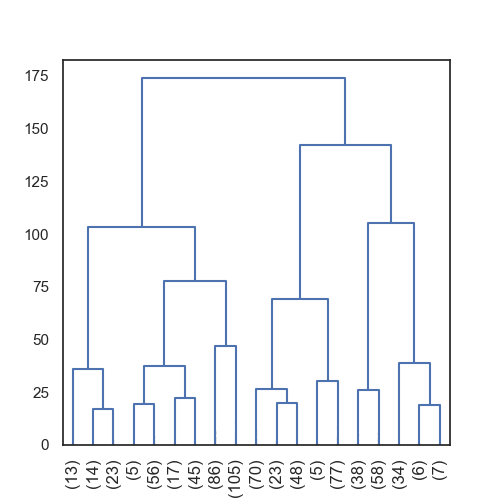

In [4]:
# For the optimal embedding we can then group members into clusters. This is represented in the generated dendrogram.

sns.set(style = "white")

# linkage and clustering for selected featurization
z = linkage(opt_embedding, method="ward")
cls = fcluster(z, NCLS, criterion='maxclust')

# plot the dendrogram
plt.figure(figsize=(5, 5))
_=dendrogram(z, truncate_mode='lastp', p=NCLS, show_contracted=True,leaf_rotation=90, color_threshold=0)


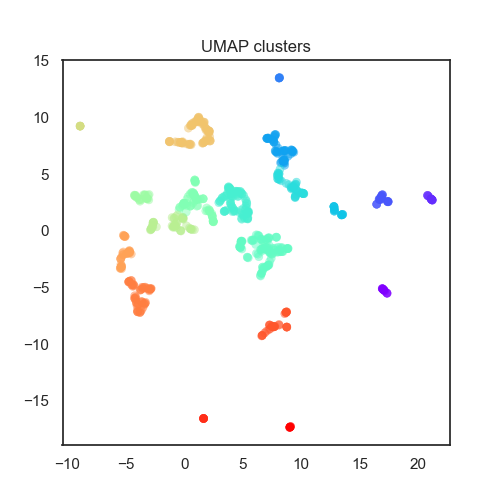

In [5]:
# With the clusters in hand we can generate a first plot showing each cluster in a separate color. Changing the "palette" value changes the color.

fig, ax1 = plt.subplots(1, 1, figsize=(5,5))

sns.scatterplot(x=opt_embedding[:,0], y=opt_embedding[:,1], s=35, alpha=0.5, linewidth=0.25, edgecolor='face', palette='rainbow', legend='full', hue=cls, ax = ax1, markers="+").set_title("UMAP clusters")
#plt.legend(bbox_to_anchor=(1.1, 1), loc=1, borderaxespad=0.)
ax1.get_legend().remove()



In [6]:
# To read in prepared scopes or specific sets of substrates we can use the following code. In this example, three scopes were prepared and the substrates were listed in .txt files in inchi format. This section ready in the individual scopes and 
# compares the inchis to the data set used for UMAP. Finally it lists the indeces that were found.

substrate_sets = []

with open("Tetrazine_Scope1.txt", "r") as f:
    substrate_sets.append(f.readlines())

with open("Tetrazine_Scope2.txt", "r") as f:
    substrate_sets.append(f.readlines())

with open("Tetrazine_Scope3.txt", "r") as f:
    substrate_sets.append(f.readlines())
    
index_groups = {}

for i, set in enumerate(substrate_sets):

    if len(set) > 0:
        index_groups[f"set{i+1}"] = []

        for j, entry in enumerate(inchis):
            
            for inchi in set:
                tmp = inchi.rstrip("\n")

                if tmp in entry:
                    index_groups[f"set{i+1}"].append(j)
                    break
    
    print(f"Set {i+1}: {len(index_groups[f'set{i+1}'])} of {len(set)} members were found.")
    print(index_groups[f'set{i+1}'])

Set 1: 16 of 18 members were found.
[0, 1, 2, 8, 9, 14, 17, 20, 22, 29, 33, 67, 90, 91, 103, 119]
Set 2: 8 of 12 members were found.
[3, 4, 7, 11, 18, 25, 187, 304]
Set 3: 17 of 24 members were found.
[5, 10, 15, 21, 26, 27, 35, 36, 41, 45, 49, 51, 55, 63, 97, 209, 276]


In [7]:
# Based on the found examples from the scopes/etc we find the coordinates and clusters they are in. The color scheme this produces is specific to the Mechanism project. For other color schemes this needs to be changed.

def get_partial_data(embedding, dict):

    first_elem = 1

    for key in dict.keys():
        indices = dict[key]
        markers.append("*")
        for index in indices:
            elem = [embedding[index][0], embedding[index][1]]

            if first_elem == 1:
                temp = np.array([elem])
                group = np.array([key])
                ind = np.array([index])
                first_elem = 0
            
            else:    
                temp = np.append(temp, [elem], axis = 0)
                group = np.append(group, [key], axis = 0)
                ind = np.append(ind, [index], axis = 0)

    return [temp, group, ind]

# THIS PORTION IS RESPONSIBLE FOR THE GROUPING (AND THUS COLORING) OF CLUSTERS IN THE NEXT BLOCK
lowest_cat_for_clusters = [3] * NCLS

for i, value in enumerate(opt_embedding):
    for index, key in enumerate(index_groups.keys()):
        for entry in index_groups[key]:
            if i == entry:
                if index < lowest_cat_for_clusters[cls[i]-1]:
                    lowest_cat_for_clusters[cls[i]-1] = index

grp = []
for i, value in enumerate(cls):
    grp.append(lowest_cat_for_clusters[value-1])
#------------------------------------------------------------

markers = []
data = get_partial_data(opt_embedding, index_groups)
coords = pd.DataFrame(data[0], columns=["UMAP1", "UMAP2"])
groups = data[1]
opt_e = pd.DataFrame(opt_embedding, columns=["UMAP1", "UMAP2"])
simple_group = [1] * len(groups)




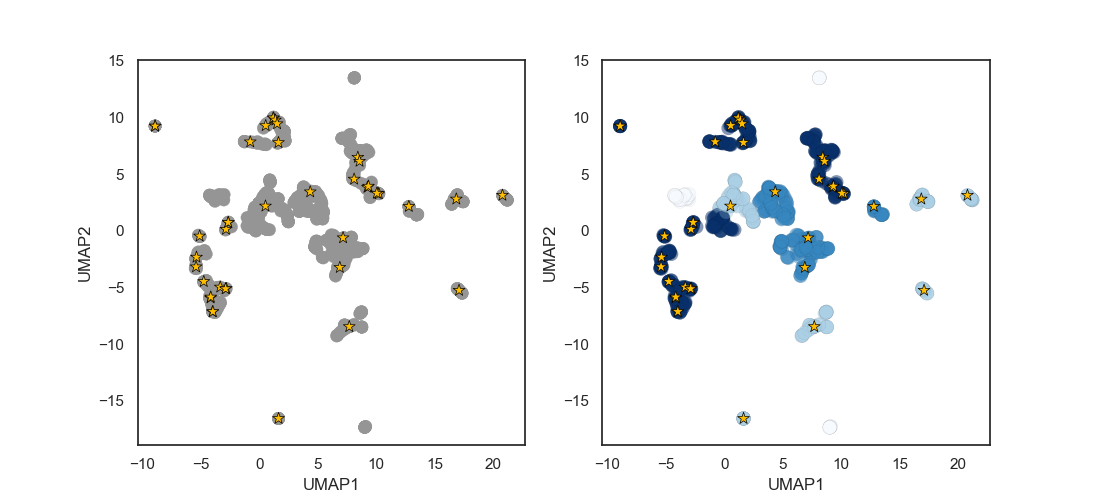

In [8]:
# Now we overlay the chemical space with the examples from the scopes.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))

sns.scatterplot(data = opt_e, x = "UMAP1", y = "UMAP2", s = 80, alpha = 1, linewidth = 0.25, edgecolor = 'face', palette = "Greys", hue=1, ax = ax1)
sns.scatterplot(data = coords, x = "UMAP1", y = "UMAP2", s = 80, alpha = 1, linewidth = 0.5, edgecolor = 'black', palette = "Wistia", markers=markers, style=groups, ax=ax1, hue=simple_group)
sns.scatterplot(data = opt_e, x = "UMAP1", y = "UMAP2", s = 100, alpha = 0.5, linewidth = 0.05, edgecolor = 'black', palette = "Blues_r", hue=grp, ax=ax2)
sns.scatterplot(data=coords, x = "UMAP1", y = "UMAP2", s = 80, alpha = 1, linewidth = 0.5, edgecolor = 'black', palette = "Wistia", markers=markers, style=groups, ax=ax2, hue=simple_group)
ax1.get_legend().remove()
ax2.get_legend().remove()


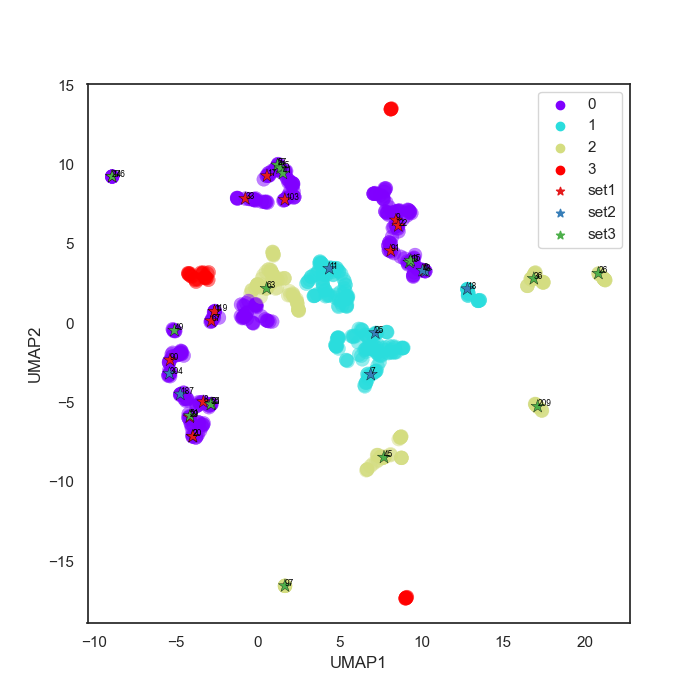

In [13]:
# This shows again the chemical space and all "scope" substrates, however, it also shows to which scope they belong and their index.

fig = plt.figure(figsize=(7, 7))

lowest_cat_for_clusters = [3] * NCLS

for i, value in enumerate(data[0]):
    plt.text(x=value[0], y=value[1], s=str(data[2][i]), fontdict=dict(color="black", size=6))

for i, value in enumerate(opt_embedding):
    for index, key in enumerate(index_groups.keys()):
        for entry in index_groups[key]:
            if i == entry:
                if index < lowest_cat_for_clusters[cls[i]-1]:
                    lowest_cat_for_clusters[cls[i]-1] = index

grp = []
for i, value in enumerate(cls):
    grp.append(lowest_cat_for_clusters[value-1])

fig = sns.scatterplot(data = opt_e, x = "UMAP1", y = "UMAP2", s = 100, alpha = 0.5, linewidth = 0.25, edgecolor = 'face', palette = "rainbow", hue=grp)
fig = sns.scatterplot(data=coords, x = "UMAP1", y = "UMAP2", s = 100, alpha = 1, linewidth = 0.25, edgecolor = 'black', palette = "Set1", markers=markers, style=groups, hue=groups)
#fig.get_legend().remove()

Cluster 1, n molecules: 13


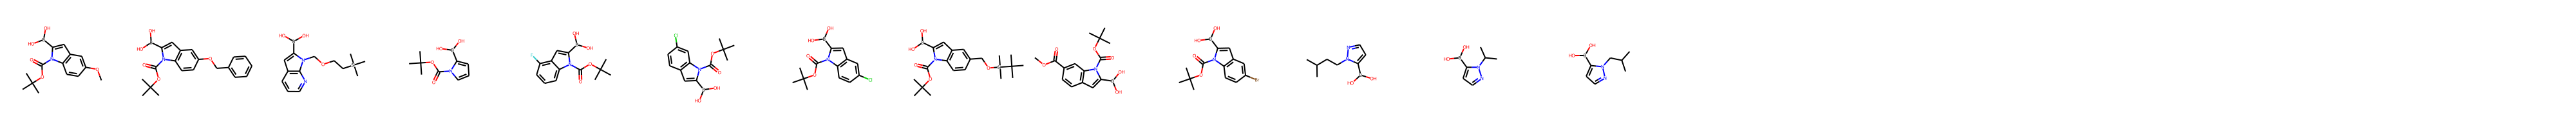

Cluster 2, n molecules: 14


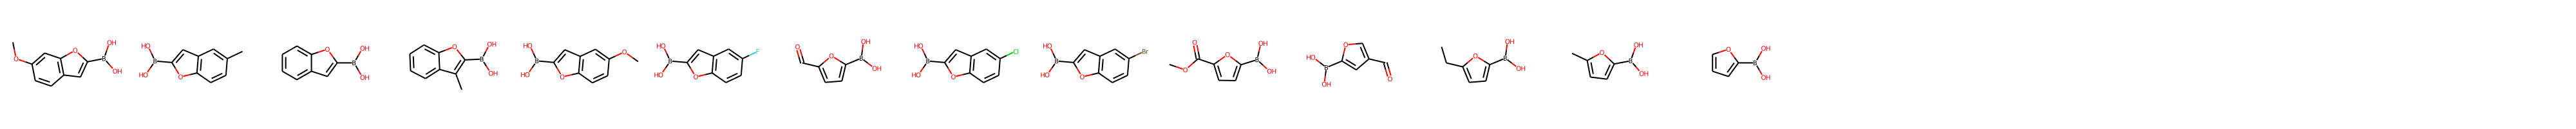

Cluster 3, n molecules: 23


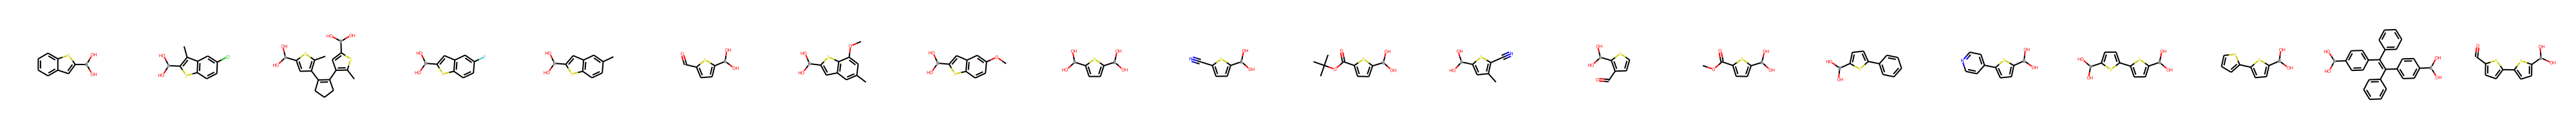

Cluster 4, n molecules: 5


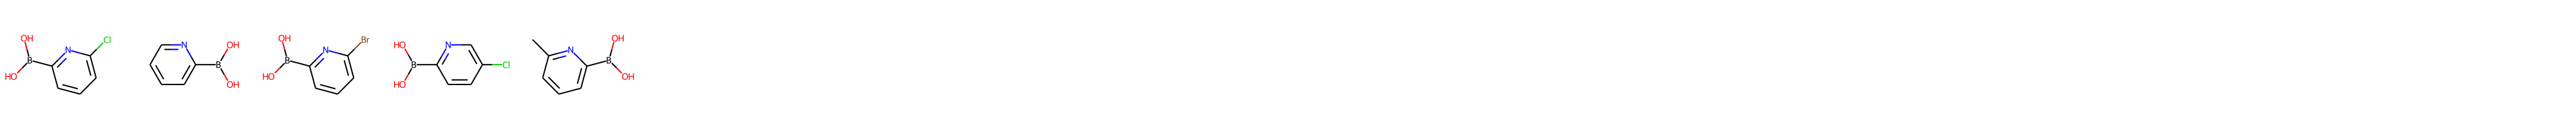

Cluster 5, n molecules: 56


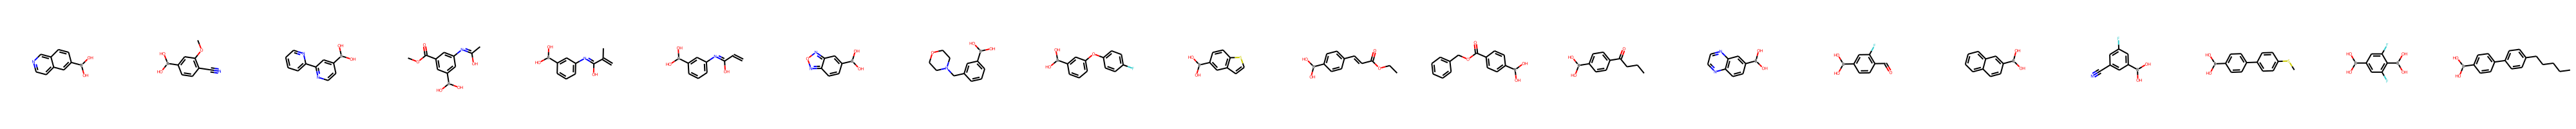

Cluster 6, n molecules: 17


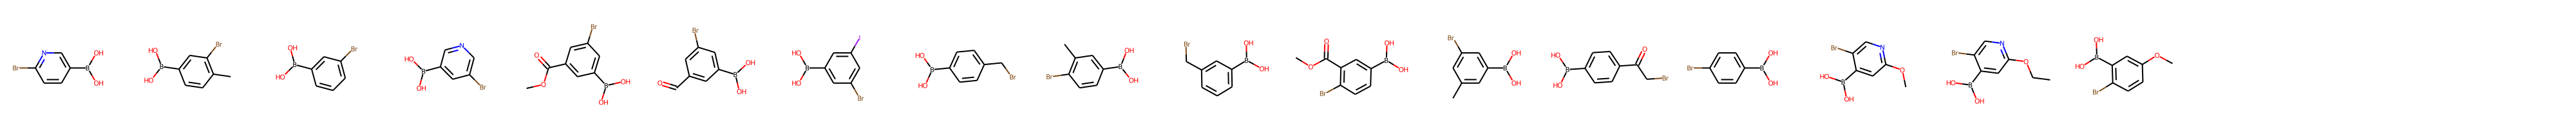

Cluster 7, n molecules: 45


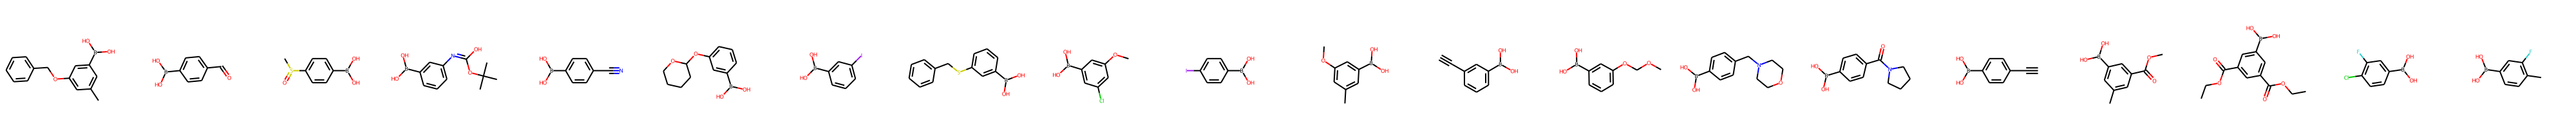

Cluster 8, n molecules: 86


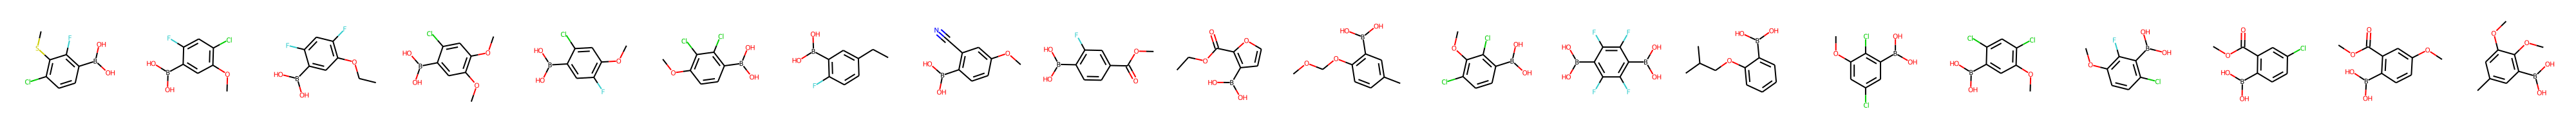

Cluster 9, n molecules: 105


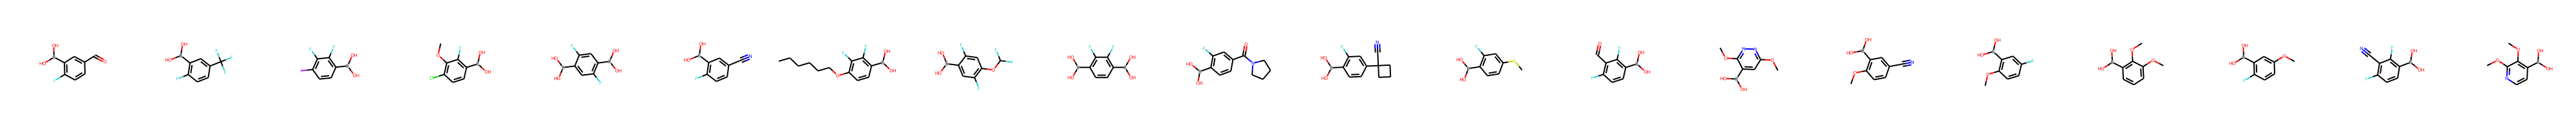

Cluster 10, n molecules: 70


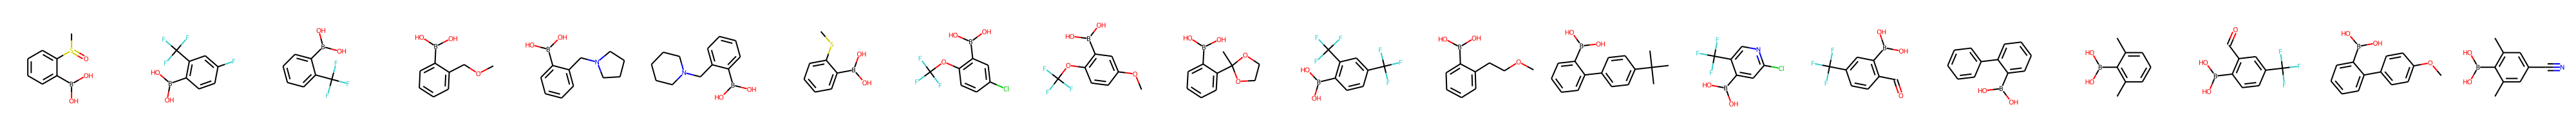

Cluster 11, n molecules: 23


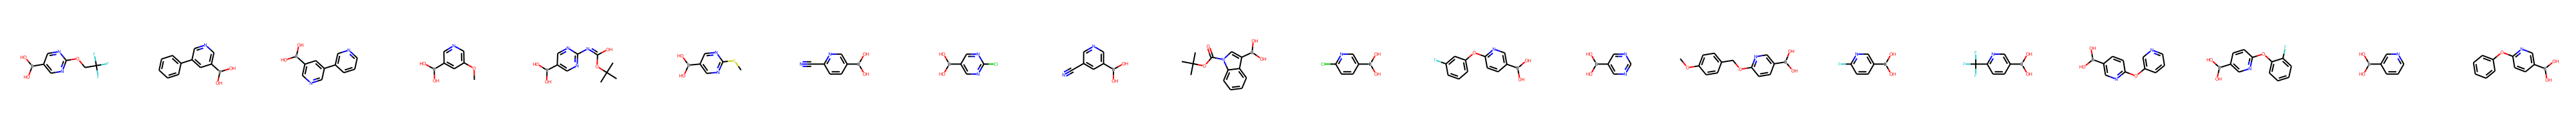

Cluster 12, n molecules: 48


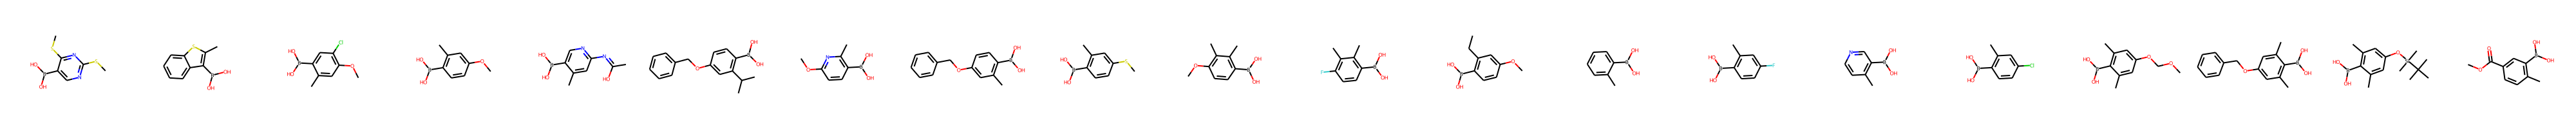

Cluster 13, n molecules: 5


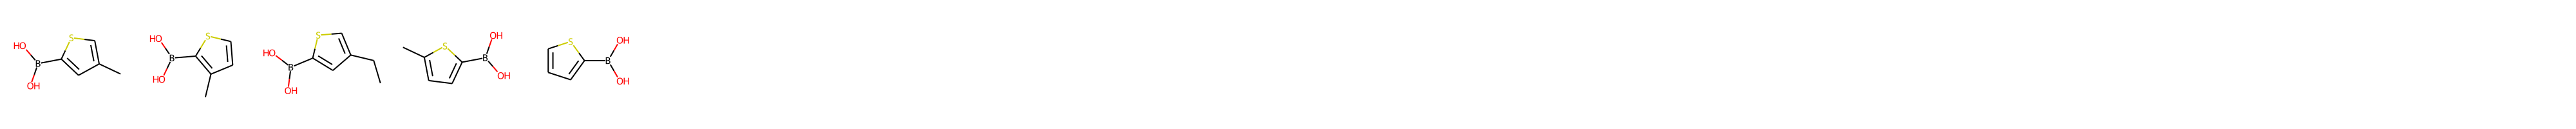

Cluster 14, n molecules: 77


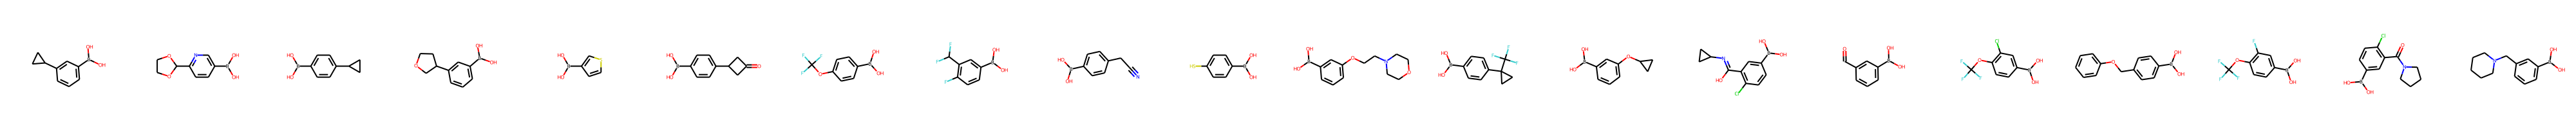

Cluster 15, n molecules: 38


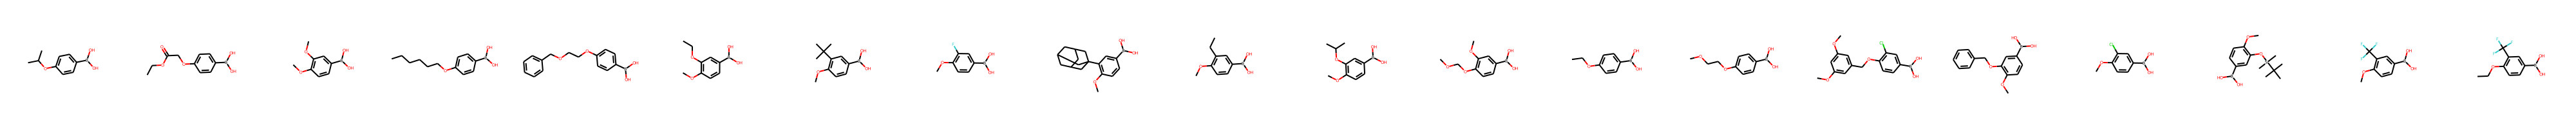

Cluster 16, n molecules: 58


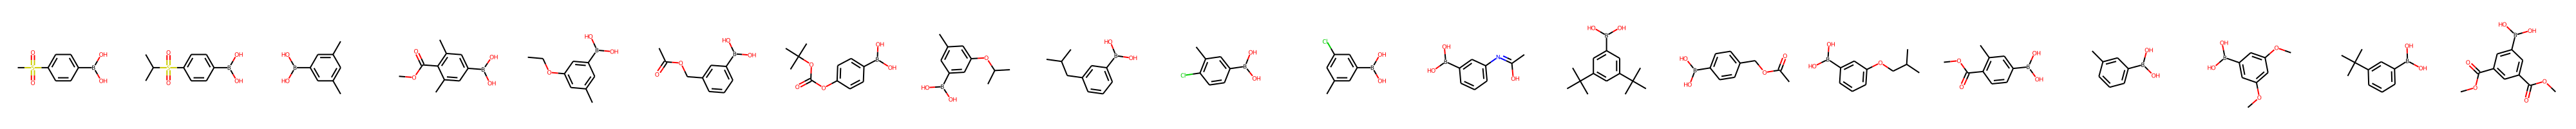

Cluster 17, n molecules: 34


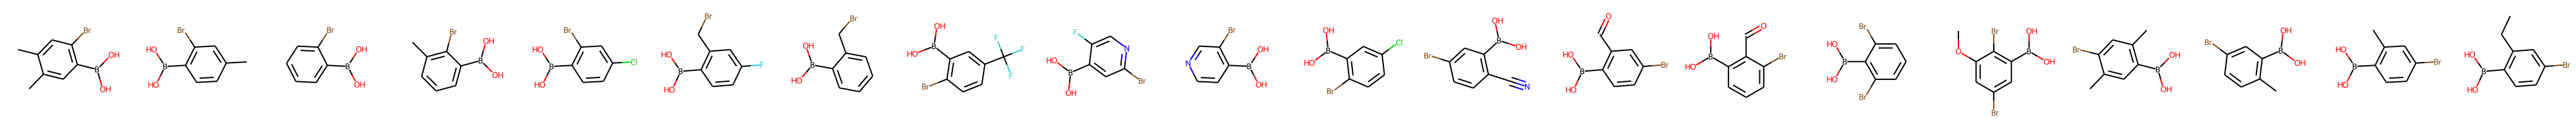

Cluster 18, n molecules: 6


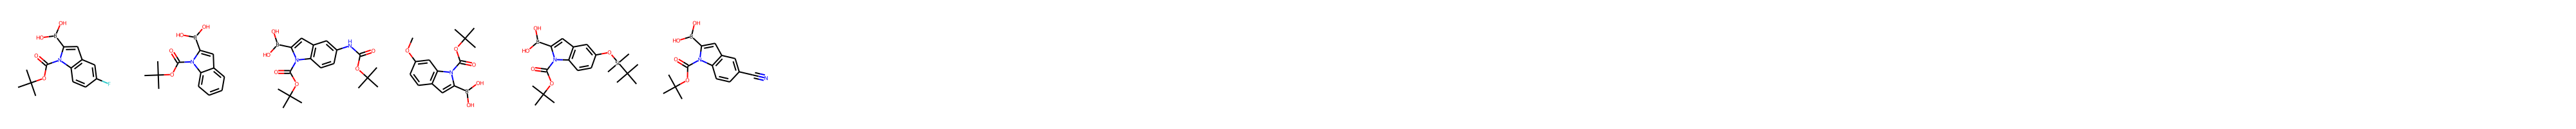

Cluster 19, n molecules: 7


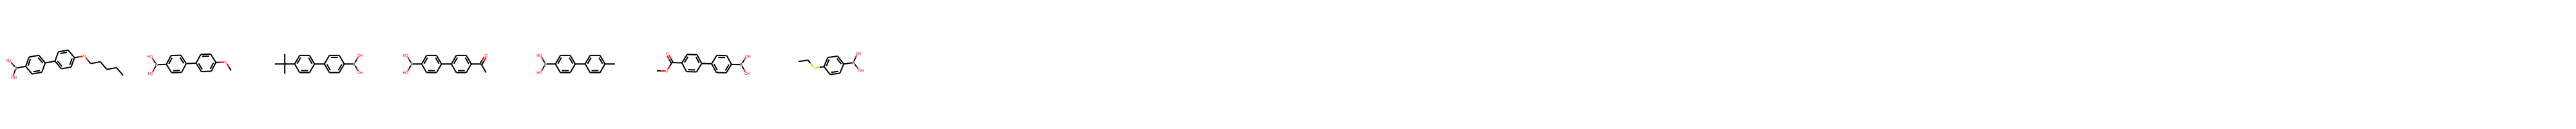

In [49]:
# We use RDkit to generate Mol files from the inchis we saved at the very beginning. These we can then use to draw examples from each cluster, or even whoole clusters. For this n_per_cluster can be changed.

# build rdkit molecules for all candidates
mols = pd.Series([Chem.MolFromInchi(x) for x in inchis]).to_frame("mol")


#How many central molecules to display?
n_per_cluster = 20

# store central candidates for
cands=[]
for group, data in mols.groupby(cls):
    # get descriptor data for this cluster
    desc_data=pd.DataFrame(opt_embedding).loc[data.index]
    # compute distances of these molecules to their center
    dists=pd.Series(cdist([desc_data.mean()], desc_data)[0], index=desc_data.index)
    # select top n central molecules
    selected=dists.sort_values().head(n_per_cluster).index
    smi=mols.loc[selected]['mol'].map(Chem.MolToSmiles)
    smi=smi.reset_index(drop=True).to_frame(f"Cluster{group}")
    cands.append(smi)
    print (f"Cluster {group}, n molecules: {len(data)}")
    ms = data['mol'].loc[selected]
    pic = Chem.Draw.MolsToGridImage(ms, molsPerRow=n_per_cluster, returnPNG = False)

    # IF THE LINE BELOW IS UNCOMMENTED IT WILL SAVE ALL PICTURES AS .PNG
    #pic.save(f"Cluster_{group}.png")
    #---------------------------------------

    display(pic)

cands = pd.concat(cands, axis=1)